# Проект по оценке и анализу А/B-тестирования

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Цель проекта:

Провести оценку результатов A/B-теста

## Входные данные и описание:

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## План проекта:

### Этап 1. Получение данных

    - импортируем библиотеки
    - откроем файлы с данными
    - изучим общую информацию данных

### Этап 2. Подготовка данных

    - проверим данные на аномалии
    - проверим пропуски и типы данных. Откорректируем, если нужно
    - проверим столбец даты и времени

### Этап 3. Оценка корректности проведения теста

- проверим соответствие данных требованиям технического задания.
- проверим время проведения теста. Оно не должно совпадать с маркетинговыми и другими активностями.
- проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

### Этап 4. Исследовательский анализ

* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя? События одинаково распределены в выборках?
* Как число событий в выборках распределено по дням?
* Как меняется конверсия в воронке в выборках на разных этапах?

### Этап 5. Оценка результатов A/B-тестирования

- Сколько пользователей в каждой экспериментальной группе?
- Проверим, находят ли статистические критерии разницу между группами.
- Проверим статистическую разницу долей z-критерием.

### Этап 6. Выводы

## Этап 1. Получение данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats as st 
import datetime as dt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

In [2]:
#загрузим данные
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')

new_user_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')

participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#посмотрим общую информацию
print('Общая информация')
marketing_events.info()
print('====================================')
print('Дубликатов в таблице:', marketing_events.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(marketing_events.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(marketing_events.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
Дубликатов в таблице: 0
Пропусков в таблице:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество уникальных значений:
name         14
regions       6
start_dt     14
finish_dt    14
dtype: int64


Дубликатов нет, пропусков нет.

In [5]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
#посмотрим общую информацию
print('Общая информация')
new_users.info()
print('====================================')
print('Дубликатов в таблице:', new_users.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(new_users.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(new_users.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
Дубликатов в таблице: 0
Пропусков в таблице:
user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество уникальных значений:
user_id       61733
first_date       17
region            4
device            4
dtype: int64


Дубликатов нет, пропусков нет.

In [7]:
new_user_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
#посмотрим общую информацию
print('Общая информация')
new_user_events.info()
print('====================================')
print('Дубликатов в таблице:', new_user_events.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(new_user_events.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(new_user_events.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
Дубликатов в таблице: 0
Пропусков в таблице:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество уникальных значений:
user_id        58703
event_dt      267268
event_name         4
details            4
dtype: int64


Дубликатов нет. Пропусков много в столбце с дополнительными данными о событиях. В процессе предобработки решим, что с ними делать. Так же нужно поменять тип данных столбца с датами

In [9]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [10]:
#посмотрим общую информацию
print('Общая информация')
participants.info()
print('====================================')
print('Дубликатов в таблице:', participants.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(participants.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(participants.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
Дубликатов в таблице: 0
Пропусков в таблице:
user_id    0
group      0
ab_test    0
dtype: int64
Количество уникальных значений:
user_id    16666
group          2
ab_test        2
dtype: int64


Аномалий в данном датасете не обнаружено.

**Итоги предварительного изучения полученных данных:**

- Формат столбцов с датами не соответствует нужному. Требуется исправление.
- Есть пропуски в одном датасете. Необходимо принять решение, что с ними делать (удалить/оставить/заменить).

 ## Этап 2. Предобработка данных

Заменим тип даты на правильный

In [11]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format="%Y-%m-%d")
new_users['first_dt'] = new_users['first_date'].dt.date

In [12]:
new_user_events['event_dt'] = pd.to_datetime(new_user_events['event_dt'], format="%Y-%m-%d")
new_user_events['date'] =  new_user_events['event_dt'].dt.date

In [13]:
# проверим
new_user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   date        440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB


Посмотрим на пропуски в группировке по событиям.

In [14]:
new_user_events.groupby('event_name')['details'].agg({'count'})

,count
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


Данные представлены только для события *purchase*, в остальных пропуск. В данном случае в столбце "details" указана сумма покупки, поэтому данные есть только для этого события.
исправлять данную аномалию не нужно, оставим как есть.

In [15]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
 4   first_dt    61733 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.4+ MB


### Этап 3. Оценка корректности проведения теста

- проверим соответствие данных требованиям технического задания.
- проверим время проведения теста. Оно не должно совпадать с маркетинговыми и другими активностями.
- проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

**Проверим, соответствуют ли предоставленные данные требованиям технического задания.**

Посмотрим на количество уникальных данных о тестировании. В техническом задании (далее ТЗ) название теста - `recommender_system_test`, обновим переменную, сделав по нему срез.

In [16]:
participants_actual = participants.query('ab_test == "recommender_system_test"')

In [17]:
participants_actual.nunique()

user_id    6701
group         2
ab_test       1
dtype: int64

- 6701 участник теста
- 2 группы теста,
- 1 тест

In [18]:
participants_actual['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

Деление по группам приемлимое = 57/43

Объединим таблицы регистрации новых пользователей и участников теста в одну. Проверим уникальность участников

In [19]:
data = new_users.merge(participants_actual, how = 'inner', left_on='user_id', right_on='user_id')

In [20]:
data.head(3)

,user_id,first_date,region,device,first_dt,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07,A,recommender_system_test
1,E6DE857AFBDC6102,2020-12-07,EU,PC,2020-12-07,B,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test


In [21]:
#посмотрим общую информацию
print('Общая информация')
data.info()
print('====================================')
print('Дубликатов в таблице:', data.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(data.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(data.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6701 non-null   object        
 1   first_date  6701 non-null   datetime64[ns]
 2   region      6701 non-null   object        
 3   device      6701 non-null   object        
 4   first_dt    6701 non-null   object        
 5   group       6701 non-null   object        
 6   ab_test     6701 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 418.8+ KB
Дубликатов в таблице: 0
Пропусков в таблице:
user_id       0
first_date    0
region        0
device        0
first_dt      0
group         0
ab_test       0
dtype: int64
Количество уникальных значений:
user_id       6701
first_date      15
region           4
device           4
first_dt        15
group            2
ab_test          1
dtype: int64


**Проверим, есть ли 15% новых пользователей из Европы в качестве участников теста**

In [22]:
print('Количество новых участников теста из Европы:', len(data.query('region == "EU"')['user_id']))

Количество новых участников теста из Европы: 6351


In [23]:
print('Количество пользователей из Европы:', len(new_users.query('region == "EU"')['user_id']))

Количество пользователей из Европы: 46270


In [24]:
print('Процент новых пользователей из Европы:', round((len(data.query('region == "EU"')['user_id'])/
      len(new_users.query('region == "EU"')['user_id'])*100)), '%')

Процент новых пользователей из Европы: 14 %


Данное требование ТЗ не соблюдено, согласно требованию, должно быть не менее 15% новых пользователей из Европы, по факту 14%.

**Проверим время проведения теста, время остановки набора новых пользователей и остановки теста.**

In [25]:
data['first_dt'].min(), data['first_dt'].max()

(datetime.date(2020, 12, 7), datetime.date(2020, 12, 21))

Даты начала и окончания регистрации участников теста соответствуют требованиям ТЗ

In [26]:
new_user_events['event_dt'].min(), new_user_events['event_dt'].max()

(Timestamp('2020-12-07 00:00:33'), Timestamp('2020-12-30 23:36:33'))

Тест закончили на 5 дней ранее, чем условлено в ТЗ. Результаты теста, в связи с этим могут быть искажены.

*Проверим не было ли маркетинговых событий в дни проведения теста.*

In [27]:
start_date = dt.datetime(2020, 12, 7) # дата запуска теста
end_date = dt.datetime(2021, 1, 4) # дата остановки теста
# создадим список дат в периоде проведения теста
date_list = pd.date_range(
            min(start_date, end_date),
            max(start_date, end_date)).strftime('%Y-%m-%d').tolist()

In [28]:
# сделаем срез маркетинговых событий по условию
marketing_events.query('start_dt in @date_list or finish_dt in @date_list')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Два глобальных события произошли в дни проведения теста: 
- **Christmas&New Year Promo** - новогодняя промо-акция,
- **CIS New Year Gift Lottery** - новогодняя лотерея.

Чуть ниже рассмотрим как повлияли эти акции на качество проведения теста.

**Проверим аудиторию теста, нет ли пользователей, участвующих в двух группах теста одновременно**

In [29]:
# найдем пересечение одинаковых значений в выборках методом numpy.intersect1d()
print(len(np.intersect1d(data.query('group == "A"')['user_id']
                         , data.query('group == "B"')['user_id'])))

0


В выборке данных нет участников, которые есть одновременно в двух группах теста.

**Проверим аудиторию теста, нет ли пользователей, участвующих в двух тестах одновременно**

Искать будем пересечение участников основного теста и участников второго теста экспериментальной группы. Даже если участники тестировались в обоих тестах в контрольной группе, на результат эксперимента это не повлияет

In [30]:
# найдем пересечение одинаковых значений в выборках 
print(len(np.intersect1d(data.query('ab_test == "recommender_system_test"')['user_id']
                         , participants.query('ab_test == "interface_eu_test" & group == "B"')['user_id'])))

783


783 пользователя участвовали одновременно в двух тестах и в экспериментальной группе 2-го теста. Данное отклонение означает несоблюдение требования ТЗ, так как уникальных участников теста становится менее 6000 человек (6701 - 783 = 5918 участников). 

In [31]:
dubl_user = np.intersect1d(data.query('ab_test == "recommender_system_test"')['user_id']
                         , participants.query('ab_test == "interface_eu_test" & group == "B"')['user_id'])

Оставим в датасете только "честных" пользователей, которые участвовали только в одном тесте.

In [32]:
data = data.query('user_id not in @dubl_user')
data.shape

(5918, 7)

**Проверим ожидаемый эффект конверсии:** 

за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%

In [33]:
# соединим таблицы с данными теста и событиями в одну
data = data.merge(new_user_events, how = 'left', left_on='user_id', right_on='user_id')
data.head()

,user_id,first_date,region,device,first_dt,group,ab_test,event_dt,event_name,details,date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,2020-12-07
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,2020-12-07
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,2020-12-08
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,2020-12-10


Расчитаем конверсию пользователей по каждому событию, с лайфтаймом в 14 дней и ограничением по дате (период анализа = 30.12.2022 минус горизонт анализа 14 дней)

In [34]:
# оформим расчеты в виде фунцции
def get_conversion(
    data,
    horizon_days,
    dimensions=[]
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    observation_date = datetime(2020, 12, 30).date()
    last_suitable_acquisition_date = datetime(2020, 12, 30).date()
    ignore_horizon=True
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days= horizon_days - 1
        )
    result_raw = data.query('first_date <= @last_suitable_acquisition_date')

    # рассчитаем лайфтайм для каждого события
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_date']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # построим таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # посчитаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # вычислим размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # объединим таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # разделим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключим все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстановим размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_date'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Посмотрим на конверсию по событиям группы **"А"**

In [35]:
conversion_raw, conversion, conversion_history = get_conversion(
    data.query('group == "A"'), 14, dimensions=['event_name']
)

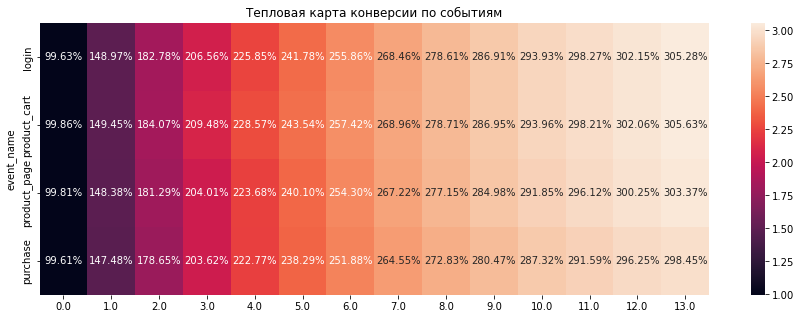

In [36]:
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по событиям')
plt.show() 

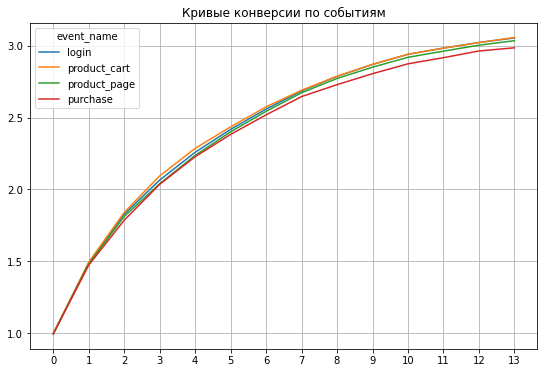

In [37]:
# построим кривые конверсии
plt.subplots(figsize=(20,6))
conversion.drop(columns=['cohort_size']).T.plot(
    grid=True, xticks=list(conversion.drop(columns=['cohort_size']).columns.values), ax=plt.subplot(1, 2, 2))
plt.title('Кривые конверсии по событиям')
plt.show()

Конверсии каждого события участников группы А на 14 день после регистрации составляет почти 300%.

Посмотрим на конверсию по событиям группы **"В"**

In [38]:
conversion_raw, conversion, conversion_history = get_conversion(
    data.query('group == "B"'), 14, dimensions=['event_name']
)

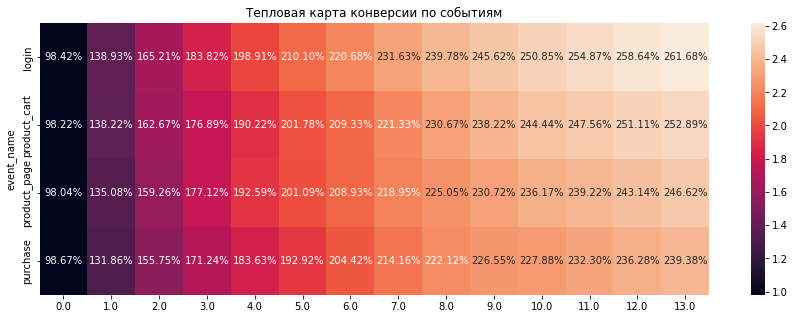

In [39]:
# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по событиям')
plt.show() 

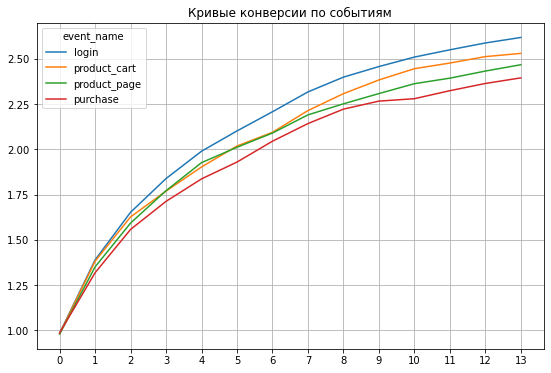

In [40]:
# построим кривые конверсии
plt.subplots(figsize=(20,6))
conversion.drop(columns=['cohort_size']).T.plot(
    grid=True, xticks=list(conversion.drop(columns=['cohort_size']).columns.values), ax=plt.subplot(1, 2, 2))
plt.title('Кривые конверсии по событиям')
plt.show()

В экспериментальной группе конверсия в событиях чуть ниже, чем в группе "А", в среднем составляет около 250% через 14 дней после регистрации.

*Оставим в датасете события, которые произошли не более 14 дней с момента регистрации.*

Для этого расчитаем лайфтайм, посмотрим на количество событий и, при необходимости, откинем неактуальные данные

In [41]:
data['lifetime'] = (data['event_dt'] - data['first_date']).dt.days
data['lifetime'].value_counts()

0.0     7181
1.0     3357
2.0     2265
3.0     1613
4.0     1316
5.0     1051
6.0      936
7.0      875
8.0      671
9.0      544
10.0     467
11.0     300
12.0     289
13.0     220
14.0     191
15.0     160
16.0      83
17.0      79
18.0      69
20.0      65
19.0      54
21.0      31
22.0      21
23.0       4
Name: lifetime, dtype: int64

Все события с лайфтаймом более 14 дней убираем из датасета

In [42]:
data = data.query('lifetime < 14')
data.head()

,user_id,first_date,region,device,first_dt,group,ab_test,event_dt,event_name,details,date,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,2020-12-07,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,2020-12-07,0.0
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,2020-12-07,0.0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,2020-12-08,1.0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,2020-12-10,3.0


In [43]:
# посчитаем ещё раз уникальных участников теста
data['user_id'].nunique()

3244

**Итоги проверки предоставленных данных теста на соблюдение требований ТЗ:**

- 14% новых пользователей из EU. Требование невыполнено.
- Даты начала и окончания регистрации новых пользователей соответствуют ТЗ.
- Дата окончания теста на 5 дней раньше заявленной в ТЗ. Требование не выполнено.
- 3244 уникальных участников теста. Требование не выполнено.
- Две группы участников теста, участники не пересекаются. Требование выполнено.
- Тестирование пересекается с двумя глобальными промо-акциями. Требование не выполнено.

В связи с тем, что несколько ключевых требований технического задания не были соблюдены, становится сложно предполагать о корректности результатов тестирования и их интерпретации.

Тем не менее анализ теста проведем и сделаем выводы.

## Этап 4. Исследовательский анализ

**Одинаково ли события на пользователя распределены в выборках?**

Посмотрим есть ли пропуски по событиям

In [44]:
data_null = data[data['event_name'].isnull()]

In [45]:
print('Клиентов без событий:', data_null['user_id'].nunique())
print('Клиентов с событиями:', data['user_id'].nunique()- data_null['user_id'].nunique())

Клиентов без событий: 0
Клиентов с событиями: 3244


Пропусков в событиях нет

Посчитаем количество событий на одного пользователя.

In [46]:
print('Среднее количество событий на пользователя:'
      , (data['event_name'].count()/data['user_id'].nunique()).round(2))

Среднее количество событий на пользователя: 6.56


Проверим наличие/отсутствие аномальных пользователей, таких у которых большое количество событий

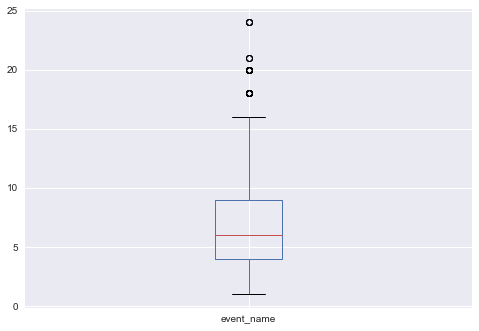

In [47]:
plt.style.use("seaborn")
data.groupby('user_id').agg({'event_name':'count'}).boxplot()
plt.show()

15 событий и больше, такие клиенты явно выбиваются из общего числа.

In [48]:
# применим метод percentile()
np.percentile(data.groupby('user_id').agg({'event_name':'count'}), [90, 95, 99])

array([12., 14., 18.])

1 % клиентов с количеством событий более 18 - выбросы

**Посмотрим на распределение событий по группам**

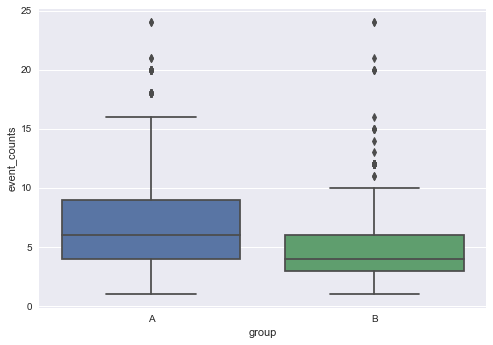

In [49]:
event_group = pd.pivot_table(data,
                   values=["event_name"],
                   index=['user_id', 'group'],
                   aggfunc=['count'])
event_group.columns = ['event_counts']
event_group = event_group.sort_values(by=['user_id','group']).reset_index()
sns.boxplot(data=event_group, x = "group",  y="event_counts")
plt.show()

In [50]:
event_group.groupby('group').agg({'event_counts':'mean'})

,event_counts
group,
A,6.945087
B,5.419708


В контрольной группе "А" среднее количество событий на пользователя - почти 7.

В группе "В" - среднее количество событий на пользователя чуть меньше - 5.4

**Как число событий в выборках распределено по дням?**

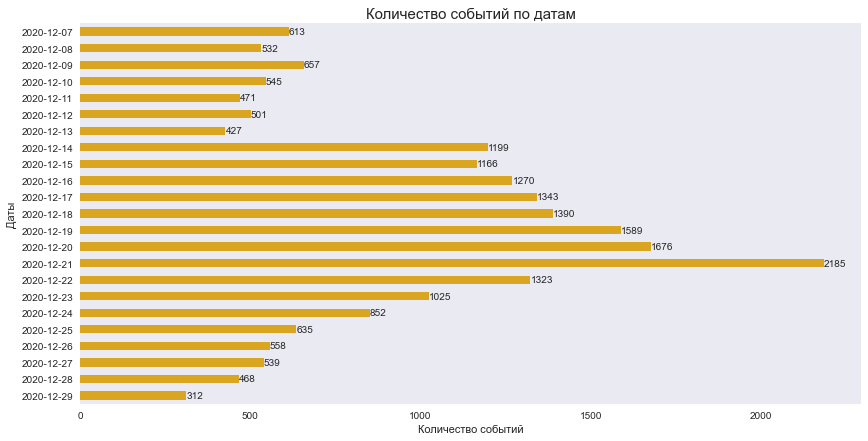

In [51]:
# посмотрим на распределение событий по датам на графике
event_name_date = data.pivot_table(index='date'
                                   , values='event_name'
                                   , aggfunc='count').sort_values(by=['date'], ascending = False)
ax = event_name_date.plot(kind='barh', legend=False, grid=False, figsize=(14,7), color="goldenrod")
for i, v in enumerate(event_name_date['event_name']):
    ax.text(v + 0, i + .0, str(v), verticalalignment='center')
plt.title('Количество событий по датам', fontsize=15)
plt.xlabel("Количество событий")
plt.ylabel("Даты")
plt.show()

Ранее мы обнаружили, что в период проведения теста проходили две промо-акции: 25 декабря - новогодняя в Америки и Европе и 30 декабря - лотерея в странах СНГ. Из графика распределения событий по дням видно, что увеличения количества событий в эти и последующие дни не обнаружено. Можно предположить, что промо-акции на качество теста не повлияли.

**Распределение событий по дням в разбивке по группам**

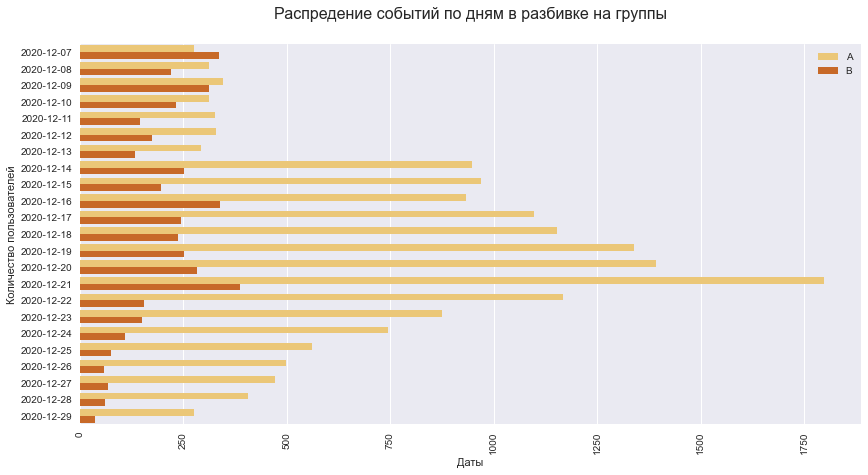

In [52]:
event_name_group = pd.pivot_table(data,
                   values=["user_id"],
                   index=['date', 'group'],
                   aggfunc=['count'])
event_name_group.columns = ['user_counts']
event_name_group = event_name_group.sort_values(by=['date','group']).reset_index()

plt.subplots(figsize=(14,7))    
sns.barplot(y = 'date', x = 'user_counts', hue = 'group', data = event_name_group, palette='YlOrBr')

ax.legend(loc = 'upper left') 
ax.grid(True)
plt.xticks(rotation=90)
plt.legend()
plt.title('Распредение событий по дням в разбивке на группы', fontsize=16, pad=25)
plt.xlabel("Даты")
plt.ylabel("Количество пользователей")
plt.show()

Практически на протяжении всего теста наблюдается большой перекос количества событий в сторону контрольной группы А. Особенно с 14 по 22 декабря.

In [53]:
#количество событий по видам
data['event_name'].value_counts()

login           9634
product_page    5952
purchase        2866
product_cart    2824
Name: event_name, dtype: int64

In [54]:
#посчитаем пользователей по каждому событию
event_count = (data
               .pivot_table(index='event_name'
                                   , values='user_id'
                                   , aggfunc={'nunique'})
               .sort_values('nunique', ascending=False)
               .reset_index()
              )
#посчитаем долю пользователей, которые хоть раз совершали событие
event_count['percent, %'] = (event_count['nunique']/data['user_id'].nunique()*100).round(1)
event_count

,event_name,nunique,"percent, %"
0,login,3243,100.0
1,product_page,2030,62.6
2,purchase,999,30.8
3,product_cart,953,29.4


Расшифруем события и опишем результат:

* *login* - вход на сайт. **100%** пользователей зашли на сайт(приложение).
* *product_page* - просмотр каталога товаров. **62,6%** пользователей просмотрели страницу продуктов.
* *purchase* - просмотр корзины. **30,8%** пользователей просмотрели корзину с добавленными продуктами.
* *product_cart* - покупка товара. **29,4%** пользователей совершили оплату.

Из данного списка событий, отсортированного по убыванию процентов конверсии, выделяется нелогичная  последовательность:
по логике перехода пользователей на следующее событие, после залогинивания и просмотра каталога товаров должно следовать добавление в корзину (вход в корзину), а в конце покупка. Процент конверсии также должен идти на убыль в такой последовательности. В нашем случае процент событий покупки больше чем просмотров в корзину. Это может означать, что, либо есть возможность купить товар, минуя просмотр корзины, либо происходила системная ошибка.


Разделим общий датафрейм на две группы

In [59]:
data_a = data.query('group == "A"')
data_b = data.query('group == "B"')

In [60]:
#посчитаем пользователей по каждому событию в группе А
event_count_a = (data_a
               .pivot_table(index='event_name'
                                   , values='user_id'
                                   , aggfunc={'nunique'})
               .sort_values('nunique', ascending=False)
               .reset_index()
              )
#посчитаем долю пользователей, которые хоть раз совершали событие
event_count_a['percent, %'] = (event_count_a['nunique']/data_a['user_id'].nunique()*100).round(1)
event_count_a

,event_name,nunique,"percent, %"
0,login,2422,100.0
1,product_page,1571,64.9
2,purchase,773,31.9
3,product_cart,728,30.1


In [61]:
#посчитаем пользователей по каждому событию в группе В
event_count_b = (data_b
               .pivot_table(index='event_name'
                                   , values='user_id'
                                   , aggfunc={'nunique'})
               .sort_values('nunique', ascending=False)
               .reset_index()
              )
#посчитаем долю пользователей, которые хоть раз совершали событие
event_count_b['percent, %'] = (event_count_b['nunique']/data_b['user_id'].nunique()*100).round(1)

event_count_b

,event_name,nunique,"percent, %"
0,login,821,99.9
1,product_page,459,55.8
2,purchase,226,27.5
3,product_cart,225,27.4


В разбивке по группам нелогичная последовательность конверсий в событиях сохраняется

В группе "А" пользователей, которые совершили хоть одно событие, больше чем в группе "В" в 3 раза.

**Построим воронку событий по группам**

In [62]:
# посчитаем количество пользовотелей на каждом шаге события в каждой группе
all_group = (data
             .pivot_table(index='event_name'
                          , columns='group'
                          ,values='user_id'
                          ,aggfunc='nunique')
            )
all_group['rank'] = [0,2,1,3]
all_group = all_group.sort_values('rank', ascending=True)

# и построим групповую воронку
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = all_group.index,
    x = all_group['A'],
    textinfo = "value+percent initial",
    marker = {"color": ["maroon", "brown", "indianred", "coral"]})
    )

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = all_group.index,
    x = all_group['B'],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ["darkolivegreen", "olivedrab", "yellowgreen", "greenyellow"]}))

fig.update_layout(
    title="Групповая воронка событий",
    font=dict(size=16)
)

Разбивка участников по группам неравномерная, в контрольной группе участников в два раза больше.

Процент конверсии на каждом шаге от события к событию в группе 'А' немного выше, чем в группе 'В'.

Нелогичная конверсия события просмотр корзины в покупку. Покупают чаще, чем смотрят корзину.

**По итогу 14 дней после регистрации эспериментальная группа не показала ожидаемого эффекта - повышение конверсии событий на 10%.** По факту оказалось снижение метрик на 3-9 % по каждому событию.

## Ежедневные метрики

Для оценки показателей событий за каждый день расчитаем количество участников по каждому событию и построим графики

In [63]:
def cumulative_function (df, date, title):
# сформируем сводную по дате и группе по срезу определенного события
    df_pivot = pd.pivot_table(df,
                   values=["user_id"],
                   index=[date, 'group'],
                   aggfunc=['nunique'])
    df_pivot.columns = ['user_counts']
    df_pivot = df_pivot.sort_values(by=[date,'group']).reset_index()
# построим количественные графики по группам
    plt.subplots(figsize=(14,6))    
    sns.barplot(x = date, y = 'user_counts', hue = 'group', data = df_pivot, palette='YlOrBr')

    ax.legend(loc = 'upper left') 
    ax.grid(True)
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(title, fontsize=16, pad=25)
    plt.xlabel("Даты")
    plt.ylabel("Количество пользователей")
    display(plt.show())

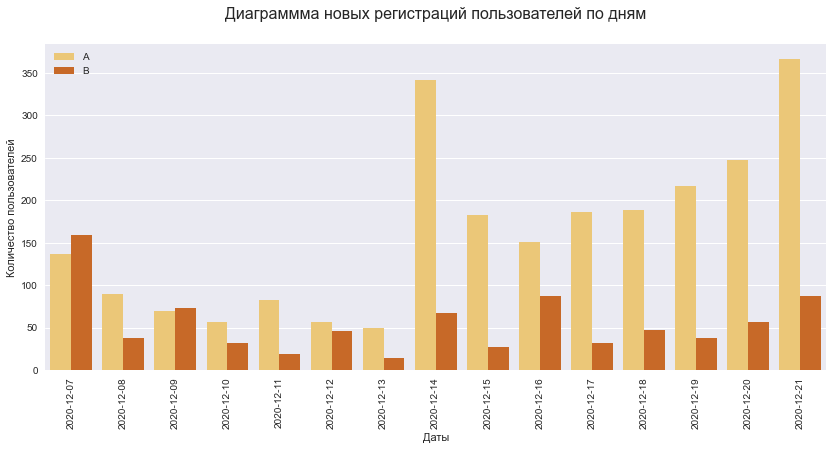

None

In [64]:
cumulative_function (data, 'first_dt', 'Диаграммма новых регистраций пользователей по дням')

На графике видно, что максимальные значения регистраций новых пользователей приходятся на первый день теста, через одну неделю и через две.

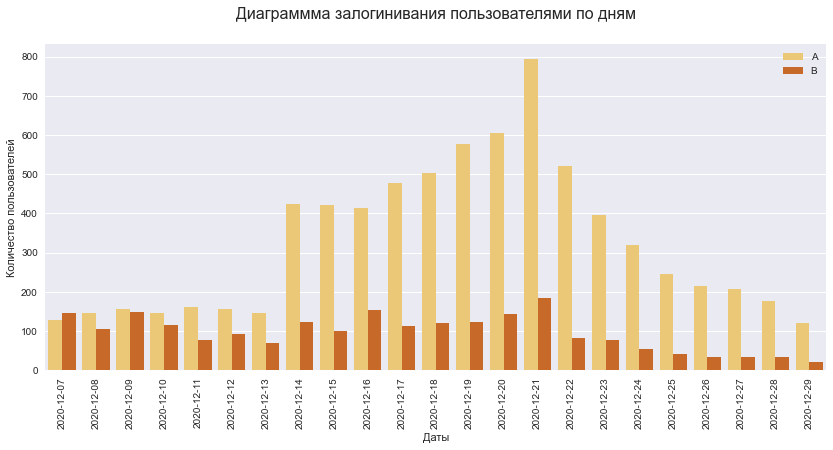

None

In [65]:
cumulative_function (data.query('event_name == "login"'), 'date', 'Диаграммма залогинивания пользователями по дням')

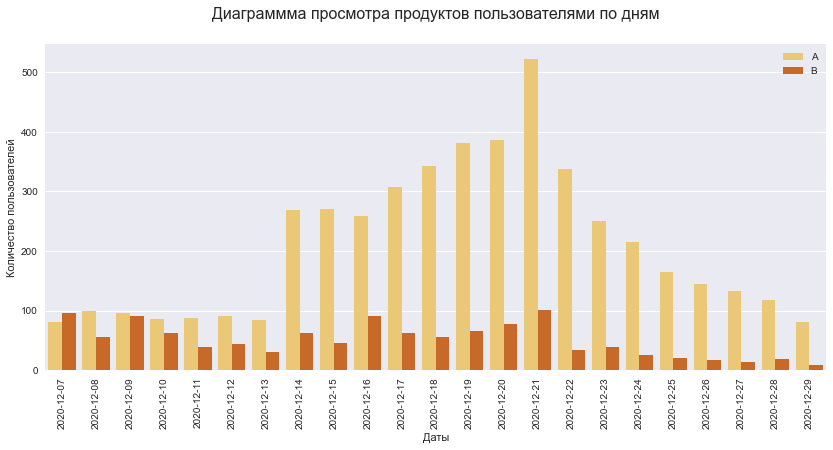

None

In [66]:
cumulative_function (data.query('event_name == "product_page"'), 'date'
                     , 'Диаграммма просмотра продуктов пользователями по дням')

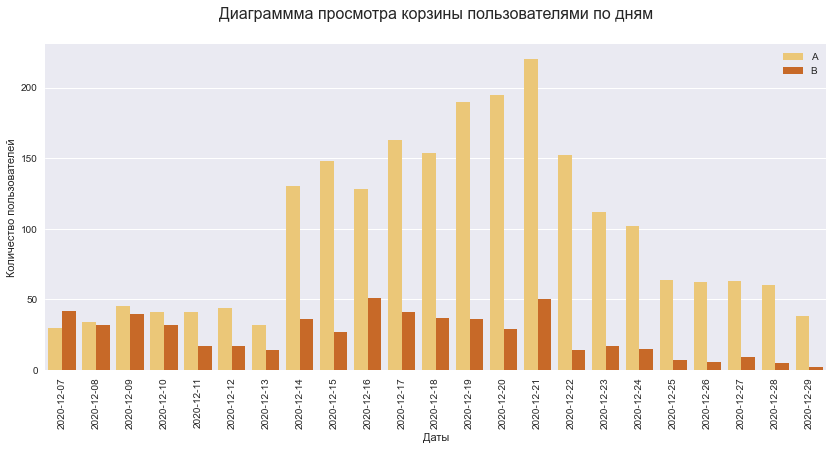

None

In [67]:
cumulative_function (data.query('event_name == "product_cart"'), 'date'
                     , 'Диаграммма просмотра корзины пользователями по дням')

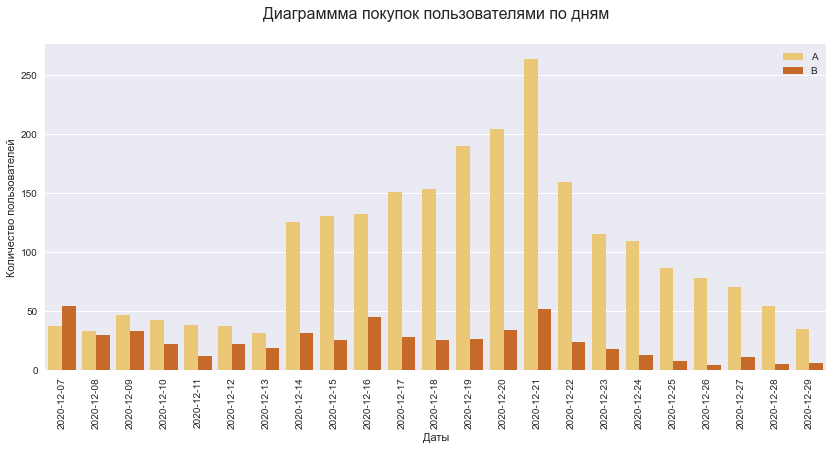

None

In [68]:
cumulative_function (data.query('event_name == "purchase"'), 'date'
                    , 'Диаграммма покупок пользователями по дням')

На всех графиках по каждому событию распределение количества участников практически одинаковое. Большой рост наблюдается через неделю после начала теста, через 14 дней показатели по событиям на пике, и после двух недель произошел  спад, продолжающийся до конца периода теста.

Выявленные несоответствие данных ТЗ:
- **14%** новых пользователей из EU, должно быть не менее 15%.
- Дата окончания теста на 4 дня раньше заявленной в ТЗ.
- **3244** уникальных участников теста, должно быть не менее 6000.
- Тестирование пересекается с двумя глобальными промо-акциями.

Некорректность данных:
- некорректное разбитие на группы, в контрольной группе участников в **три раза больше**, чем в тестируемой.
- аномальная активность участников группы "А" с 14 по 21 декабря.

Так как, выборки в группах имеют разное количество участников, а количество проводимых z-тестов будет несколько, для исключения ошибок I-го рода, применим поправку Бонферонни. 

## Изучение результатов эксперимента

Проведение статистического анализа А-В-теста, в данном случае, является скорее дополнительным подтверждением несоответствующих данных техническому заданию и некорректным проведением теста.

**Посмотрим сколько пользователей в каждой экспериментальной группе**

In [69]:
users_group = data.groupby('group').agg({'user_id':'nunique'}).reset_index()
users_group.set_index('group', inplace=True)
users_group

,user_id
group,
A,2422
B,822


**Проверим, находят ли статистические критерии разницу между выборками групп А и В.**

Для этого:
   * посчитаем число пользователей, совершивших это событие в каждой из групп
   * посчитаем долю пользователей, совершивших это событие
   * проверим, будет ли отличие между группами статистически достоверным для всех событий

Сгруппируем количество пользователей по группам и событиям

In [70]:
all_group = (data
             .pivot_table(index='event_name'
                          , columns='group'
                          ,values='user_id'
                          ,aggfunc='nunique')
            )
all_group

group,A,B
event_name,,
login,2422,821
product_cart,728,225
product_page,1571,459
purchase,773,226


Проверим статистическую значимость двух групп по всем событиям. Воспользуемся методом *z-теста.*

Сформируем нулевую и альтернативную гипотезы:
* **Нулевая гипотеза, Н0:** разницы между выборками двух групп нет
* **Альтернативная гипотеза, Н1:** присутствует разница между выборками двух групп

**Создадим функцию для проверки статистической значимости выборок контрольных и других групп по всем событиям**

In [71]:
def groups_z_test(group_1, group_2, event): 
    alpha = .05/4 # критический уровень статистической значимости с поправкой Бонферонни
    # разделено на 4 (количество проверок)
    
    ratio = np.array([all_group.loc[event, group_1]     #количество пользователей, совершивших определенное событие 
                      , all_group.loc[event, group_2]])  #в проверяемых группах
    trials = np.array([users_group.loc[group_1]
                       , users_group.loc[group_2]])   #количество пользователей в группах
    
    
    # доля пользователей в первой группе:
    p1 = ratio[0]/trials[0]
    # доля пользователей во второй группе:
    p2 = ratio[1]/trials[1]

    # доля пользователей в комбинированном датасете:
    p_combined = (ratio[0] + ratio[1]) / (trials[0] + trials[1])

    # разница долей в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('для групп {} и {} при событии {}, p-значение: {p_value}'.format(group_1, group_2, event, p_value=p_value.round(2)))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными') 

In [72]:
# создадим список событий для функции
event_list = all_group.index.to_list()

In [73]:
# циклом переберем каждое событие и применим функцию для проверки статистической значимости
for event in event_list:
    groups_z_test('A', 'B', event)
    print()

для групп A и B при событии login, p-значение: [0.09]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

для групп A и B при событии product_cart, p-значение: [0.14]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными

для групп A и B при событии product_page, p-значение: [0.]
Отвергаем нулевую гипотезу: между выборками есть значимая разница

для групп A и B при событии purchase, p-значение: [0.02]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными



**Итог:**
Нулевая гипотеза отвергнута только при тестировании выборок события **product_page**. Возможно в этом и есть причина нелогичной последовательности конверсии

## Выводы

**В процессе анализа было выявлено несоответствие данных техническому заданию и неккоректность проведения теста:**

Выявленные несоответствие данных ТЗ:
- 14% новых пользователей из EU, должно быть не менее 15%.
- Дата окончания теста на 4 дня раньше заявленной в ТЗ.
- **3244** уникальных участников теста, должно быть не менее 6000.
- Тестирование пересекается с двумя глобальными промо-акциями.

Неккоректность проведения теста:
- некорректное разбитие на группы, в контрольной группе участников в 3 раза больше, чем в тестируемой.
- аномальная активность участников группы "А" с 14 по 21 декабря.

**Ключевые наблюдения анализа:**

* Среднее количество событий на пользователя: 7 - в группе "А", 5 - в группе "В"

* Также была выявлена нелогичная последовательность шагов событий в обоих группах теста. После события просмотр продукта идет сразу покупка, а после только просмотр корзины. Данная аномалия скорее всего означает, что у пользователей была возможность совершать быстрые покупки, миную шаг просмотра корзины.

* Анализ результатов теста показал, что значимой разницы между выборками по событиям практически нет, кроме события *product_page* (просмотр карточек товара). Тест показал, что в этом событии между группами вероятна значимая разница.

**По итогу 14 дней после регистрации эспериментальная группа не показала ожидаемого эффекта - повышение конверсии событий на 10%:**
- конверсии в просмотр карточек товаров — событие product_page = **минус 9%**,
- просмотры корзины — product_cart = **минус 3%**,
- покупки — purchase = **минус 4%**.

**Исходя из выводов о несоответсвии данных и выявленных нарушений проведения теста, можно считать А-В-тестирование несостоявшимся, результаты теста нерепрезентативны.**